In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt


import pandas as pd


In [2]:
df1 = pd.read_csv('PROJECT_DATA/FOOD-DATA-GROUP1.csv')
df2 = pd.read_csv('PROJECT_DATA/FOOD-DATA-GROUP2.csv')
df3 = pd.read_csv('PROJECT_DATA/FOOD-DATA-GROUP3.csv')
df4 = pd.read_csv('PROJECT_DATA/FOOD-DATA-GROUP4.csv')
df5 = pd.read_csv('PROJECT_DATA/FOOD-DATA-GROUP5.csv')

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,food,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,...,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density
0,0,0,cream cheese,51,5.0,2.9,1.3,0.200,0.8,0.500,...,0.008,14.100,0.082,0.027,1.300,0.091,15.5,19.100,0.039,7.070
1,1,1,neufchatel cheese,215,19.4,10.9,4.9,0.800,3.1,2.700,...,99.500,0.034,0.100,8.500,0.088,117.300,129.2,0.054,0.700,130.100
2,2,2,requeijao cremoso light catupiry,49,3.6,2.3,0.9,0.000,0.9,3.400,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,5.400
3,3,3,ricotta cheese,30,2.0,1.3,0.5,0.002,1.5,0.091,...,0.097,41.200,0.097,0.096,4.000,0.024,30.8,43.800,0.035,5.196
4,4,4,cream cheese low fat,30,2.3,1.4,0.6,0.042,1.2,0.900,...,22.200,0.072,0.008,1.200,0.098,22.800,37.1,0.034,0.053,27.007


In [3]:
# Check shape before cleaning
df.shape[0]

2395

In [4]:
# Remove rows with missing values in key numeric columns
df = df.dropna(subset=[
    "Protein", "Fat", "Carbohydrates", "Caloric Value",
    "Sugars", "Dietary Fiber", "Saturated Fats",
    "Monounsaturated Fats", "Polyunsaturated Fats",
    "Sodium", "Potassium"
])

In [5]:
# Check shape after cleaning - We're expecting the same number of rows since the dataset seems complete
df.shape[0]


2395

In [6]:
# Prepare feature matrix X using relevant nutritional columns
feature_cols = [
    "Protein", "Fat", "Carbohydrates", "Caloric Value",
    "Sugars", "Dietary Fiber", "Saturated Fats",
    "Monounsaturated Fats", "Polyunsaturated Fats",
    "Sodium", "Potassium"
]

X = df[feature_cols]


In [7]:
# Explore basic statistics of key nutritional columns
df[["Protein", "Fat", "Carbohydrates", "Caloric Value"]].describe()


,Protein,Fat,Carbohydrates,Caloric Value
count,2395.000000,2395.000000,2395.000000,2395.000000
mean,13.400777,10.176276,18.589021,223.769520
std,32.294246,29.008915,29.406134,384.728244
min,0.000000,0.000000,0.000000,0.000000
25%,0.800000,0.300000,0.500000,44.500000
50%,3.500000,2.100000,6.800000,117.000000
75%,13.300000,9.400000,25.050000,258.000000
max,560.300000,550.700000,390.200000,6077.000000


In [8]:
# Test filtering for high-protein, high-carb foods
# df[(df["Protein"] >= 10) & (df["Carbohydrates"] >=30)].filter(items=["food", "Protein", "Carbohydrates", "Caloric Value"])

In [9]:
# Assign labels or target variable y

def assign_label(row):
    # Muscle Gain
    if row["Protein"] >= 20 or (row["Protein"] >= 15 and row["Caloric Value"] >= 250):
       return "Muscle Gain"

    # Endurance
    if row["Carbohydrates"] >= 30 or row["Sugars"] >= 12 or \
      (row["Carbohydrates"] >= 20 and row["Sodium"] >= 140):
       return "Endurance"

    # Weight Loss
    if (row["Caloric Value"] < 150) and (row["Fat"] < 5) and \
    (row["Carbohydrates"] < 20 or row["Dietary Fiber"] >=3 or row["Protein"] >=10):
       return "Weight Loss"

    # Default
    return "No Category"

In [10]:
df["Label"] = df.apply(assign_label, axis=1)
df["Label"].value_counts()

Label
Weight Loss    1040
Muscle Gain     500
Endurance       473
No Category     382
Name: count, dtype: int64

In [11]:
df.head()

,Unnamed: 0.1,Unnamed: 0,food,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,...,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density,Label
0,0,0,cream cheese,51,5.0,2.9,1.3,0.200,0.8,0.500,...,14.100,0.082,0.027,1.300,0.091,15.5,19.100,0.039,7.070,No Category
1,1,1,neufchatel cheese,215,19.4,10.9,4.9,0.800,3.1,2.700,...,0.034,0.100,8.500,0.088,117.300,129.2,0.054,0.700,130.100,No Category
2,2,2,requeijao cremoso light catupiry,49,3.6,2.3,0.9,0.000,0.9,3.400,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,5.400,Weight Loss
3,3,3,ricotta cheese,30,2.0,1.3,0.5,0.002,1.5,0.091,...,41.200,0.097,0.096,4.000,0.024,30.8,43.800,0.035,5.196,Weight Loss
4,4,4,cream cheese low fat,30,2.3,1.4,0.6,0.042,1.2,0.900,...,0.072,0.008,1.200,0.098,22.800,37.1,0.034,0.053,27.007,Weight Loss


In [12]:
# Create training data excluding "No Category"
train_df = df[df["Label"] != "No Category"].copy()

# Assign feature matrix X and target vector y for training
X = train_df[feature_cols].values
y = train_df["Label"].values

# Use LabelEncoder to convert string labels to integers
le = LabelEncoder()

# Fit and transform the labels - This will assign integer labels automatically
y_encoded = le.fit_transform(y)

# Show list of classes
list(le.classes_)

['Endurance', 'Muscle Gain', 'Weight Loss']

In [13]:
# Use StandardScaler to standardize features
scaler = StandardScaler()

# Compute mean and standard deviation of each feature and scale each row
X_scaled = scaler.fit_transform(X)

In [14]:
# Test 20% of data
# Stratify to maintain class distribution in train and test sets to keep ratio of classes
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [15]:
# Define parameter combinations for GridSearchCV
# The first parameter is the number of weak learners (n_estimators)
# The second parameter is the learning rate


n_estimators_list = [50, 100, 200, 300]
learning_rates = [0.1, 0.3, 0.5, 1.0, 2.0]


param_grid = {
    'n_estimators': n_estimators_list,
    'learning_rate': learning_rates
}

print("Running GridSearchCV for AdaBoostClassifier:")
grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="f1_macro"
)

grid_search.fit(X_scaled, y_encoded)

print("Best params:", grid_search.best_params_)
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cols = [
    'rank_test_score', 'mean_test_score', 'std_test_score',
    'param_n_estimators', 'param_learning_rate'
]
display(cv_results_df.sort_values('rank_test_score')[cols].head(20))


Running GridSearchCV for AdaBoostClassifier:
Best params: {'learning_rate': 0.3, 'n_estimators': 200}
Best CV F1 Score: 0.9833


,rank_test_score,mean_test_score,std_test_score,param_n_estimators,param_learning_rate
6,1,0.983318,0.006370,200,0.3
7,1,0.983318,0.006370,300,0.3
9,3,0.981987,0.008099,100,0.5
10,4,0.981303,0.007760,200,0.5
11,4,0.981303,0.007760,300,0.5
5,6,0.981243,0.008135,100,0.3
3,7,0.977633,0.009640,300,0.1
8,8,0.977548,0.010155,50,0.5
2,9,0.974804,0.010731,200,0.1
4,10,0.972006,0.005332,50,0.3


In [16]:
# Choose best parameters based on grid search results 
best_params = grid_search.best_params_

clf = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42,
    algorithm='SAMME'
)

clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3, n_estimators=200,
                   random_state=42)

Accuracy: 0.9851116625310173
F1 Score (macro): 0.982916888180046

Classification Report:
               precision    recall  f1-score   support

   Endurance       0.97      0.97      0.97        95
 Muscle Gain       1.00      0.98      0.99       100
 Weight Loss       0.99      1.00      0.99       208

    accuracy                           0.99       403
   macro avg       0.98      0.98      0.98       403
weighted avg       0.99      0.99      0.99       403

Confusion Matrix (rows = true labels, columns = predicted labels):
             Endurance  Muscle Gain  Weight Loss
Endurance           92            0            3
Muscle Gain          2           98            0
Weight Loss          1            0          207


<Figure size 600x400 with 0 Axes>

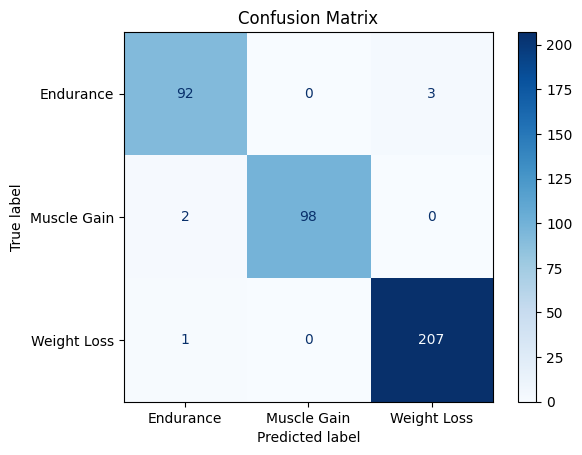

In [17]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix (numeric)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (rows = true labels, columns = predicted labels):")
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

# Confusion Matrix (plot)
plt.figure(figsize=(6,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [18]:
cv_recall = cross_val_score(clf, X_scaled, y, cv = 5, scoring = 'recall_macro')
cv_precision = cross_val_score(clf, X_scaled, y, cv = 5, scoring = 'precision_macro')
cv_f1 = cross_val_score(clf, X_scaled, y, cv = 5, scoring = 'f1_macro')
cv_accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring = 'accuracy')

print("\nMETRICS")
print("Accuracy scores:", cv_accuracy)
print("Average Accuracy:", cv_accuracy.mean())
print("\nRecall scores:", cv_recall)
print("Average Recall:", cv_recall.mean())
print("\nPrecision scores:", cv_precision)
print("Average Precision:", cv_precision.mean())
print("\nF1 scores:", cv_f1)
print("Average F1:", cv_f1.mean())


METRICS
Accuracy scores: [0.99503722 0.98014888 0.98511166 0.98507463 0.97761194]
Average Accuracy: 0.9845968667827119

Recall scores: [0.99679487 0.97333333 0.98155533 0.98066694 0.96808511]
Average Recall: 0.9800871163177994

Precision scores: [0.99312715 0.98765432 0.98135557 0.98843466 0.98617512]
Average Precision: 0.9873493625282496

F1 scores: [0.99491747 0.9798218  0.98130162 0.98436853 0.9761814 ]
Average F1: 0.9833181650273348


In [19]:
unlabeled_df = df[df["Label"] == "No Category"].copy()
X_unlabeled = unlabeled_df[feature_cols].values
X_unlabeled_scaled = scaler.transform(X_unlabeled)

unlabeled_df["ML_Prediction"] = le.inverse_transform(clf.predict(X_unlabeled_scaled))


In [20]:
print(unlabeled_df.shape)
unlabeled_df.head(100)


(382, 39)


,Unnamed: 0.1,Unnamed: 0,food,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,...,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density,Label,ML_Prediction
0,0,0,cream cheese,51,5.0,2.9,1.3,0.2,0.8,0.5,...,0.082,0.027,1.300,0.091,15.5,19.100,0.039,7.070,No Category,Weight Loss
1,1,1,neufchatel cheese,215,19.4,10.9,4.9,0.8,3.1,2.7,...,0.100,8.500,0.088,117.300,129.2,0.054,0.700,130.100,No Category,Endurance
6,6,6,gruyere cheese,116,9.1,5.3,2.8,0.5,0.1,0.1,...,0.094,10.100,0.002,169.400,22.7,0.079,1.100,300.694,No Category,Weight Loss
7,7,7,cheddar cheese,113,9.3,5.3,2.6,0.3,0.9,0.1,...,0.077,7.600,0.063,127.400,21.3,0.009,1.000,215.530,No Category,Weight Loss
12,12,12,swiss cheese,98,7.7,4.6,2.0,0.3,0.4,0.0,...,0.024,8.300,0.062,143.500,18.0,0.031,1.100,237.396,No Category,Weight Loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,268,268,chicken crispy wings kentucky fried chicken,148,10.1,2.1,3.3,3.8,5.1,0.0,...,0.300,9.700,0.015,84.500,98.1,0.003,0.500,40.161,No Category,Endurance
269,269,269,egg white delight mcdonalds,250,16.0,4.0,18.0,4.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,16.000,No Category,Endurance
273,273,273,crispy chicken wing kentucky fried chicken,104,5.3,1.1,1.7,1.8,1.3,0.0,...,0.400,11.000,0.085,99.400,116.6,0.033,0.800,32.851,No Category,Weight Loss
274,274,274,chicken strips burger king,105,5.5,1.0,1.5,2.7,7.4,0.0,...,0.005,0.200,9.700,0.036,104.8,113.400,0.070,20.168,No Category,Weight Loss


In [21]:
unlabeled_df.to_csv("adaboost_unlabeled_with_predictions.csv", index=False)


In [22]:
muscle_gain_df = df[df["Label"] == "Muscle Gain"].copy()
X_muscle_gain = muscle_gain_df[feature_cols].values
X_muscle_gain_scaled = scaler.transform(X_muscle_gain)

muscle_gain_df["ML_Prediction"] = le.inverse_transform(clf.predict(X_muscle_gain_scaled))

In [23]:
muscle_gain_df.to_csv("adaboost_muscle_gain_with_predictions.csv", index=False)
